<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

This notebook contains all functions related to the scoring of peptide-spectrum-matches (PSMS).

In brief, this notebook includes the following:

- Functions for target-decoy based FDR estimation
- X!tandem based scoring of PSMs
- Machine learning based scoring of PSMs
- Protein grouping by the razor approach

## Filtering

The filtering functions are essential base functions for scoring in AlphaPept. They make sure that only the 'best precursor per spectum' and the 'best spectrum per precursor' is used.

Recall from the search that when having feautres, `raw_idx` refers to the actual index from the raw data. Otherwise it is`query_data`.

For filtering, we have several functions. When applying for a score, we first use [`filter_score`](https://mannlabs.github.io/alphapept/score.html#filter_score) and then [`filter_precursor`](https://mannlabs.github.io/alphapept/score.html#filter_precursor).
[`filter_score`](https://mannlabs.github.io/alphapept/score.html#filter_score) is keeping the best score per experimental spectrum. First we rank by score for each `query_idx`. As we have multiple hits for each experimental spectrum from the search we only want to keep the best one.

When performing feature finding, we assign multiple possible features to each experimental spectrum. The idea here is that a spectrum could originate from various precursors. To disentangle these psms we can use the following modes:

* `single`: This mode will only keep one feature per experimental spectrum (the one with the highest score and the closest distance). Each feature can only occur once.
* `multiple`: Allow multiple features per experimental spectrum. Each feature can only occur once.

[`filter_precursor`](https://mannlabs.github.io/alphapept/score.html#filter_precursor) is intended for the case that a precursor (charge + sequence) occurs more than once. Only the one with the highest score will be kept.

In [1]:
#| echo: false
#| output: asis
show_doc(filter_score)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L16){target="_blank" style="float:right; font-size:smaller"}

### filter_score

>      filter_score (df:pandas.core.frame.DataFrame, mode:str='multiple')

Filter psms feature table by keeping only the best scoring psm per experimental spectrum.

TODO: psms could still have the same score when having modifications at multiple positions that are not distinguishable.
Only keep one.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    mode (str, optional): string specifying which mode to use for psms filtering. The two options are 'single' and 'multiple'. 'single' will only keep one feature per experimental spectrum. 'multiple' will allow multiple features per experimental spectrum. In either option, each feature can only occur once. Defaults to 'multiple'.

Returns:
    pd.DataFrame: table containing the filtered psms results.

In [2]:
#| echo: false
#| output: asis
show_doc(filter_precursor)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L58){target="_blank" style="float:right; font-size:smaller"}

### filter_precursor

>      filter_precursor (df:pandas.core.frame.DataFrame)

Filter psms feature table by precursor.
Allow each precursor only once.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.

Returns:
    pd.DataFrame: table containing the filtered psms results.

## Q-Values

[`get_q_values`](https://mannlabs.github.io/alphapept/score.html#get_q_values) is used to calculate q-values from FDR values. The direct relationship is illustrated further down in the notebook. 

In [3]:
#| echo: false
#| output: asis
show_doc(get_q_values)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L86){target="_blank" style="float:right; font-size:smaller"}

### get_q_values

>      get_q_values (fdr_values:numpy.ndarray)

Calculate q-values from fdr_values.

Args:
    fdr_values (np.ndarray): np.ndarray of fdr values.

Returns:
    np.ndarray: np.ndarray of q-values.

## FDR

The employed FDR strategy is based on a classical target-decoy competition approach. The procedure works as follows:
1. Consider only the best scoring target or decoy PSM per spectrum. 
2. Sort all PSMs by decreasing scores.
3. Estimate the FDR as #decoys / #targets, where #targets (#decoys) is the number of positive target (decoy) PSMs at a given score threshold t (i.e. PSMs with scores higher than t).
4. Convert the estimated FDR to q-values by selecting the minimum FDR at which the identification could be made, i.e. the lowest score threshold t that could be set to include an identification without increasing the number of false positives.
5. Report the set of target PSMs with q-values smaller or equal to the selected `fdr_level`.

Informative literature describing and discussing different FDR estimation approaches for shotgun proteomics can be found here (the implemented strategy in alphapept is referred to as T-TDC in this article):
> Keich, Uri et al. "Improved False Discovery Rate Estimation Procedure for Shotgun Proteomics." Journal of proteome research vol. 14,8 (2015): 3148-61. <https://pubs.acs.org/doi/10.1021/acs.jproteome.5b00081>

In [4]:
#| echo: false
#| output: asis
show_doc(cut_fdr)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L112){target="_blank" style="float:right; font-size:smaller"}

### cut_fdr

>      cut_fdr (df:pandas.core.frame.DataFrame, fdr_level:float=0.01,
>               plot:bool=True, cut:bool=True)

Cuts a dataframe with a given fdr level

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
    plot (bool, optional): flag to enable plot. Defaults to 'True'.
    cut (bool, optional): flag to cut above fdr threshold. Defaults to 'True'.

Returns:
    float: numerical value of the applied score cutoff
    pd.DataFrame: df with psms within fdr

Note that the test function for cut_fdr is further down in the notebook to also test protein-level FDR.

Simulation of random scores for 50'000 measurements (corresponding to spectra). Simulated are decoys, true targets and false targets. We assume a false traget raio (pi0) of 0.8 and a mean score difference of 3.5.

Simulated score distribution for a separate target and decoy database search:

Simulated score distribution for a corresponding concatinated target-decoy database search with target-decoy-competition:

Application of the [`cut_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_fdr) function to the simulated target-decoy competition dataset saved in `TDC`:

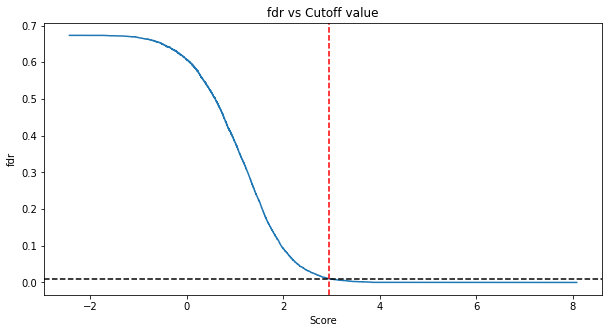

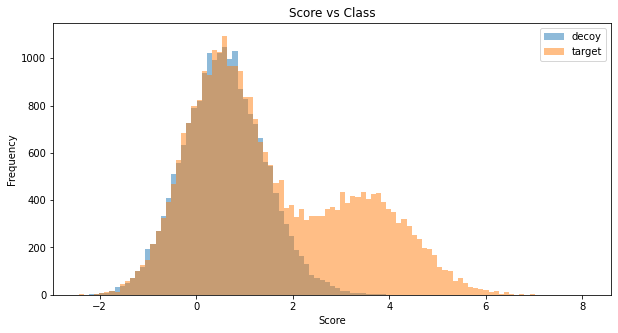

In [ ]:
cval, cut_TDC = cut_fdr(TDC, fdr_level=0.01)

Evaluation of the FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach. The true FDR is capped by the selected fraction of false targets (pi0 = 0.8) and by the effect of target decoy competition. Similarly, the true positive rate (TPR) is limited by the effect of target decoy competition and can only reach 1 in cases where not a single decoy scores higher than a true target.

The following figure illustrates the difference between `fdr` and `q_value`.

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Global FDR

The [`cut_global_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_global_fdr) function has two specific applications:
1. **Estimate q-values on the peptide and protein level** <br/>
The concept here is based on selecting the best scoring precursor per peptide (or protein) to then estimate the FDR by target-decoy competition using the [`cut_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_fdr) function.
2. **Estimate q-values across an entire dataset on either precursor, peptide or protein level** <br/>
The concept here is based on selecting the best scoring precursor, peptide or protein signal across an entire dataset to then estimate the FDR by target-decoy competition using the [`cut_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_fdr) function.

This strategy was extensively tested and discussed in the following publications:

* Nesvizhskii, Alexey I. "A survey of computational methods and error rate estimation procedures for peptide and protein identification in shotgun proteomics." Journal of proteomics vol. 73,11 (2010): 2092-123. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2956504/> 

* Savitski, Mikhail M et al. "A Scalable Approach for Protein False Discovery Rate Estimation in Large Proteomic Data Sets." Molecular & cellular proteomics : MCP vol. 14,9 (2015): 2394-404. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4563723/>

* The, Matthew et al. "Fast and Accurate Protein False Discovery Rates on Large-Scale Proteomics Data Sets with Percolator 3.0." Journal of the American Society for Mass Spectrometry vol. 27,11 (2016): 1719-1727. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5059416/>

* Gupta, Nitin, and Pavel A Pevzner. "False discovery rates of protein identifications: a strike against the two-peptide rule." Journal of proteome research vol. 8,9 (2009): 4173-81. 
<https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3398614/>

In [5]:
#| echo: false
#| output: asis
show_doc(cut_global_fdr)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L195){target="_blank" style="float:right; font-size:smaller"}

### cut_global_fdr

>      cut_global_fdr (data:pandas.core.frame.DataFrame,
>                      analyte_level:str='sequence', fdr_level:float=0.01,
>                      plot:bool=True, **kwargs)

Function to estimate and filter by global peptide or protein fdr

Args:
    data (pd.DataFrame): psms table of search results from alphapept.
    analyte_level (str, optional): string specifying the analyte level to apply the fdr threshold. Options include: 'precursor', 'sequence', 'protein_group' and 'protein'. Defaults to 'sequence'.
    fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
    plot (bool, optional): flag to enable plot. Defaults to 'True'.

Returns:
    pd.DataFrame: df with filtered results

Similar to the sequence level simulations we can simulatae score distributions for peptides beloning to proteins. In our simulation we assumed a poisson distribution for the number of peptides for each protein centered at 4 peptides. 

Application of the [`cut_global_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_global_fdr) function to the simulated protein-level target-decoy competition dataset saved in `TDC_prot`:

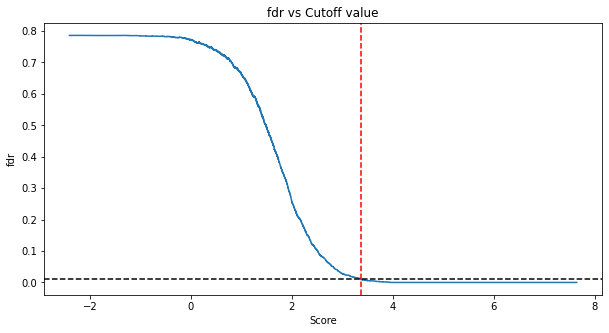

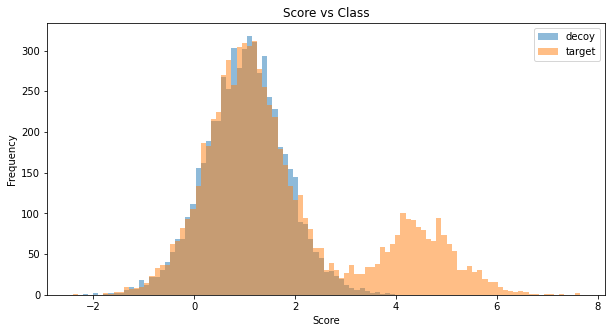

In [ ]:
cut_TDC_prot = cut_global_fdr(TDC_prot, fdr_level=0.01, analyte_level='protein')

Evaluation of the protein-level FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach:

Investigating the peptide-level statistics after protein-level FDR filtering shows a conservative pattern.

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Scoring

### X!tandem scoring

* [`get_x_tandem_score`](https://mannlabs.github.io/alphapept/score.html#get_x_tandem_score) performs scoring of PSMs according to the X!tandem strategy:

* [`score_x_tandem`](https://mannlabs.github.io/alphapept/score.html#score_x_tandem) first calls [`get_x_tandem_score`](https://mannlabs.github.io/alphapept/score.html#get_x_tandem_score) and and subsequently applies the [`cut_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_fdr) function to filter PSMs at the specified `fdr_level`.

> X!Tandem, Craig,R. and Beavis,R.C. (2003) Rapid Commun. Mass Spectrom., 17, 2310-2316

In [6]:
#| echo: false
#| output: asis
show_doc(filter_with_score)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L338){target="_blank" style="float:right; font-size:smaller"}

### filter_with_score

>      filter_with_score (df:pandas.core.frame.DataFrame)

Filters the psms table by using the score column, no fdr filter.
TODO: Remove redundancy with score functions, see issue: #275

Args:
    df (pd.DataFrame): psms table of search results from alphapept.

Returns:
    pd.DataFrame: psms table filtered for no feature or precursor to be assigned multiple times.

In [7]:
#| echo: false
#| output: asis
show_doc(filter_with_x_tandem)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L317){target="_blank" style="float:right; font-size:smaller"}

### filter_with_x_tandem

>      filter_with_x_tandem (df:pandas.core.frame.DataFrame)

Filters the psms table by using the x_tandem score, no fdr filter.
TODO: Remove redundancy with score functions, see issue: #275

Args:
    df (pd.DataFrame): psms table of search results from alphapept.

Returns:
    pd.DataFrame: psms table with an extra 'score' column for x_tandem, filtered for no feature or precursor to be assigned multiple times.

In [8]:
#| echo: false
#| output: asis
show_doc(score_generic)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L293){target="_blank" style="float:right; font-size:smaller"}

### score_generic

>      score_generic (df:pandas.core.frame.DataFrame, fdr_level:float=0.01,
>                     plot:bool=True, **kwargs)

Filters the psms table by using a generic score and filtering the results for fdr_level.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.

Returns:
    pd.DataFrame: psms table with an extra 'score' column for the generic score, filtered for no feature or precursor to be assigned multiple times.

In [9]:
#| echo: false
#| output: asis
show_doc(get_generic_score)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L277){target="_blank" style="float:right; font-size:smaller"}

### get_generic_score

>      get_generic_score (df:pandas.core.frame.DataFrame)

Function to calculate the a generic score

Args:
    df (pd.DataFrame): psms table of search results from alphapept.

Returns:
    np.ndarray: np.ndarray with x_tandem scores

In [10]:
#| echo: false
#| output: asis
show_doc(score_x_tandem)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L254){target="_blank" style="float:right; font-size:smaller"}

### score_x_tandem

>      score_x_tandem (df:pandas.core.frame.DataFrame, fdr_level:float=0.01,
>                      plot:bool=True, **kwargs)

Filters the psms table by using the x_tandem score and filtering the results for fdr_level.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.

Returns:
    pd.DataFrame: psms table with an extra 'score' column for x_tandem, filtered for no feature or precursor to be assigned multiple times.

In [11]:
#| echo: false
#| output: asis
show_doc(get_x_tandem_score)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L235){target="_blank" style="float:right; font-size:smaller"}

### get_x_tandem_score

>      get_x_tandem_score (df:pandas.core.frame.DataFrame)

Function to calculate the x tandem score

Args:
    df (pd.DataFrame): psms table of search results from alphapept.

Returns:
    np.ndarray: np.ndarray with x_tandem scores

### Score and filter PSMs by any specified score

[`score_psms`](https://mannlabs.github.io/alphapept/score.html#score_psms) uses the specified [`score`](https://mannlabs.github.io/alphapept/search.html#score) and applies the [`cut_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_fdr) function to filter PSMs at the specified `fdr_level`. [`filter_score`](https://mannlabs.github.io/alphapept/score.html#filter_score) and [`filter_precursor`](https://mannlabs.github.io/alphapept/score.html#filter_precursor) are applied to only report the best PSM per acquired spectrum and the best signal per precursor (i.e. sequence + charge combination).

In [12]:
#| echo: false
#| output: asis
show_doc(score_psms)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L359){target="_blank" style="float:right; font-size:smaller"}

### score_psms

>      score_psms (df:pandas.core.frame.DataFrame, score:str='hits_y',
>                  fdr_level:float=0.01, plot:bool=True, **kwargs)

Uses the specified score in df to filter psms and to apply the fdr_level threshold.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    score (str, optional): string specifying the column in df to use as score. Defaults to 'hits_y'.
    fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
    plot (bool, optional): flag to enable plot. Defaults to 'True'.

Returns:
    pd.DataFrame: filtered df with psms within fdr

## Machine learning based scoring of PSMs

* [`get_ML_features`](https://mannlabs.github.io/alphapept/score.html#get_ml_features) extracts additional scoring metrics for the machine learning, including the number of amino acids per precursor, the number of missed cleavages and the logarithmic number of times the same peptide occurs in the set of PSMs

* [`train_RF`](https://mannlabs.github.io/alphapept/score.html#train_rf) trains a random forest classifier for scoring all PSMs. For this, we use the scikit-learn library.
    * First, a machine learning pipeline is created including the sklearn `StandardScaler` and `RandomForestClassifier`. The `StandardScaler` is used to standardize all features by removing the mean and scaling to unit variance. For details on the `RandomForestClassifier` see: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>.
    * Next, a grid search is initialized for testing the hyperparameter space (`max_depth` and `max_leaf_nodes`) of the random forest classifier by a 5-fold cross-validation using `GridSearchCV`.
    * To train the classifier, we first select a suitable set of PSMSs. This is achieved by an initial scoring and FDR estimation of the input PSMs based on the `ini_score`. Only targets below the `train_fdr_level` cutoff are considered for training the classifier. To ensure a balanced dataset for training (i.e. same number of targets and decoys), the number of PSMs per category is selected to be the minimum of either the number of high scoring targets below the `train_fdr_level` cutoff or the overall number of decoys among the PSMs. `min_train` specifies the minimum number of targets and decoys that should be available. 
    * Once a balanced set of PSMs is established, the PSMs are split into a training and test set accoring to the `test_size` argument using `train_test_split` from sklearn while ensuring the PSMs are split in a stratified fashion (i.e. equal number of targets and decoys in both the training and test sets).
    * The grid search and training of the random forest classifier is performed on the training set of PSMs. The `GridSearchCV` returns the classifier which performed best across all cross-validation hold-out sets according to the `scoring` function (classification *'accuracy'* is set as default score). The grid search is parallelize dinto `n_jobs`.
    * Next, the trained classifier is applied to the testing set of PSMs and the test score is reported. 
    * If `plot` is enabled, a figure illustrating the weights of each feature is produced.
    * Finally the function returns the trained random forest classifier for subsequent application to the entire set of PSMs or for transfering to a different dataset. 

* [`score_ML`](https://mannlabs.github.io/alphapept/score.html#score_ml) applies a classifier trained by [`train_RF`](https://mannlabs.github.io/alphapept/score.html#train_rf) to a complete set of PSMs. It calls the [`cut_fdr`](https://mannlabs.github.io/alphapept/score.html#cut_fdr) function and filters for the specified `fdr_level`. [`filter_score`](https://mannlabs.github.io/alphapept/score.html#filter_score) and [`filter_precursor`](https://mannlabs.github.io/alphapept/score.html#filter_precursor) are applied to only report the best PSM per acquired spectrum and the best signal per precursor (i.e. sequence + charge combination).

In [13]:
#| echo: false
#| output: asis
show_doc(filter_with_ML)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L606){target="_blank" style="float:right; font-size:smaller"}

### filter_with_ML

>      filter_with_ML (df:pandas.core.frame.DataFrame,
>                      trained_classifier:sklearn.model_selection._search.GridSe
>                      archCV, features:list=None, **kwargs)

Filters the psms table by using the x_tandem score, no fdr filter.
TODO: Remove redundancy with score functions, see issue: #275

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    trained_classifier (GridSearchCV): GridSearchCV object returned by train_RF.
    features (list): list with features returned by train_RF. Defaults to 'None'.

Returns:
    pd.DataFrame: psms table with an extra 'score' column from the trained_classifier by ML, filtered for no feature or precursor to be assigned multiple times.

In [14]:
#| echo: false
#| output: asis
show_doc(score_ML)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L576){target="_blank" style="float:right; font-size:smaller"}

### score_ML

>      score_ML (df:pandas.core.frame.DataFrame,
>                trained_classifier:sklearn.model_selection._search.GridSearchCV
>                , features:list=None, fdr_level:float=0.01, plot:bool=True,
>                **kwargs)

Applies a trained ML classifier to df and uses the ML score to filter psms and to apply the fdr_level threshold.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    trained_classifier (GridSearchCV): GridSearchCV object returned by train_RF.
    features (list): list with features returned by train_RF. Defaults to None.
    fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
    plot (bool, optional): flag to enable plot. Defaults to True.

Returns:
    pd.DataFrame: filtered df with psms within fdr

In [15]:
#| echo: false
#| output: asis
show_doc(train_RF)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L430){target="_blank" style="float:right; font-size:smaller"}

### train_RF

>      train_RF (df:pandas.core.frame.DataFrame,
>                exclude_features:list=['precursor_idx', 'fragment_ion_idx',
>                'fasta_index', 'feature_rank', 'raw_rank', 'score_rank',
>                'db_idx', 'feature_idx', 'precursor', 'query_idx', 'raw_idx',
>                'sequence', 'decoy', 'sequence_naked', 'target'],
>                train_fdr_level:float=0.1, ini_score:str='x_tandem',
>                min_train:int=1000, test_size:float=0.8, max_depth:list=[5, 25,
>                50], max_leaf_nodes:list=[150, 200, 250], n_jobs:int=-1,
>                scoring:str='accuracy', plot:bool=False, random_state:int=42,
>                **kwargs)

Function to train a random forest classifier to separate targets from decoys via semi-supervised learning.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    exclude_features (list, optional): list with column names of features to exclude for ML. Defaults to ['precursor_idx','fragment_ion_idx','fasta_index','feature_rank','raw_rank','score_rank','db_idx', 'feature_idx', 'precursor', 'query_idx', 'raw_idx','sequence','decoy','sequence_naked','target'].
    train_fdr_level (float, optional): Only targets below the train_fdr_level cutoff are considered for training the classifier. Defaults to 0.1.
    ini_score (str, optional): Initial score to select psms set for semi-supervised learning. Defaults to 'x_tandem'.
    min_train (int, optional): Minimum number of psms in the training set. Defaults to 1000.
    test_size (float, optional): Fraction of psms used for testing. Defaults to 0.8.
    max_depth (list, optional): List of clf__max_depth parameters to test in the grid search. Defaults to [5,25,50].
    max_leaf_nodes (list, optional): List of clf__max_leaf_nodes parameters to test in the grid search. Defaults to [150,200,250].
    n_jobs (int, optional): Number of jobs to use for parallelizing the gridsearch. Defaults to -1, which in GridSearchCV corresponds to 'use all available cores'.
    scoring (str, optional): Scoring method for the gridsearch. Defaults to 'accuracy'.
    plot (bool, optional): flag to enable plot. Defaults to 'False'.
    random_state (int, optional): Random state for initializing the RandomForestClassifier. Defaults to 42.

Returns:
    [GridSearchCV, list]: GridSearchCV: GridSearchCV object with trained RandomForestClassifier. list: list of features used for training the classifier.

In [16]:
#| echo: false
#| output: asis
show_doc(get_ML_features)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L402){target="_blank" style="float:right; font-size:smaller"}

### get_ML_features

>      get_ML_features (df:pandas.core.frame.DataFrame, protease:str='trypsin',
>                       **kwargs)

Uses the specified score in df to filter psms and to apply the fdr_level threshold.

Args:
    df (pd.DataFrame): psms table of search results from alphapept.
    protease (str, optional): string specifying the protease that was used for proteolytic digestion. Defaults to 'trypsin'.

Returns:
    pd.DataFrame: df including additional scores for subsequent ML.

## Protein grouping

What is a protein group? A introduction and explanation can be found here [1]:

```
The proteome is characterized by a relatively high sequence redundancy. This results from different evolutionary processes and the presence of isoforms. In bottom-up proteomics, this situation leads to the problem that often a peptide cannot be uniquely associated with one protein of origin, which makes it impossible to unambiguously claim the presence of one protein over another. MaxQuant resolves this issue by collapsing all proteins that cannot be distinguished based on the identified peptides into protein groups.
The rule is that if all peptides of a given protein are a subset of the peptides used for identification of another protein, these proteins will be merged in a protein group. A more complex situation arises when two protein groups are identified with distinct peptides, except for one that is shared between the two. In this case, the two groups cannot be combined, as they contain group-unique peptides and will thus be reported separately in the MaxQuant output table. Depending on the user-defined setting, the shared peptide will not be used for quantification (unique peptides only), or it will be used for the quantification of the protein group with a larger number of associated peptides (unique + razor peptides).

```

In AlphaPept we employ the following strategy:
First, we check whether a peptide is proteotypic, meaning that the peptide can only belong to one protein. For peptides that are shared between multiple proteins, we employ a razor approach. 

We create a network and add all connections between the peptides and proteins. Then, we extract all connected components, referring to all peptides and proteins that are connected. For a cluster of connected components, we then iterate over all proteins and count the number of peptides that are connected to the particular protein. The protein with the most peptides will then be the razor protein.

We remove this protein and the respective peptides and continue with the extraction from the cluster until no more peptides are present.

For efficient implementation, the proteins and peptides are encoded as indexes. To distinguish proteins from peptides, proteins have a leading 'p'.

* [1] Tyanova, S., Temu, T. & Cox, J. The MaxQuant computational platform for mass spectrometry-based shotgun proteomics. Nat Protoc 11, 2301–2319 (2016). https://doi.org/10.1038/nprot.2016.136

In [17]:
#| echo: false
#| output: asis
show_doc(perform_protein_grouping)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L831){target="_blank" style="float:right; font-size:smaller"}

### perform_protein_grouping

>      perform_protein_grouping (data:pandas.core.frame.DataFrame,
>                                pept_dict:dict, fasta_dict:dict, **kwargs)

Wrapper function to perform protein grouping by razor approach

Args:
    data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
    pept_dict (dict): A dictionary mapping peptide indices to the originating proteins as a list.
    fasta_dict (dict): A dictionary with fasta sequences.

Returns:
    pd.DataFrame: alphapept results table now including protein level information.

In [18]:
#| echo: false
#| output: asis
show_doc(get_protein_groups)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L762){target="_blank" style="float:right; font-size:smaller"}

### get_protein_groups

>      get_protein_groups (data:pandas.core.frame.DataFrame, pept_dict:dict,
>                          fasta_dict:dict, decoy=False, callback=None,
>                          **kwargs)

Function to perform protein grouping by razor approach.
This function calls [`assign_proteins`](https://mannlabs.github.io/alphapept/score.html#assign_proteins) and [`get_shared_proteins`](https://mannlabs.github.io/alphapept/score.html#get_shared_proteins).
ToDo: implement callback for solving
Each protein is indicated with a p -> protein index

Args:
    data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
    pept_dict (dict): A dictionary mapping peptide indices to the originating proteins as a list.
    fasta_dict (dict): A dictionary with fasta sequences.
    decoy (bool, optional): Defaults to False.
    callback (bool, optional): Defaults to None.

Returns:
    pd.DataFrame: alphapept results table now including protein level information.

In [19]:
#| echo: false
#| output: asis
show_doc(get_shared_proteins)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L673){target="_blank" style="float:right; font-size:smaller"}

### get_shared_proteins

>      get_shared_proteins (data:pandas.core.frame.DataFrame,
>                           found_proteins:dict, pept_dict:dict)

Assign peptides to razor proteins. 

Args:
    data (pd.DataFrame): psms table of scored and filtered search results from alphapept, appended with `n_possible_proteins`.
    found_proteins (dict): dictionary mapping psms indices to proteins
    pept_dict (dict): dictionary mapping peptide indices to the originating proteins as a list

Returns:
    dict: dictionary mapping peptides to razor proteins

In [20]:
#| echo: false
#| output: asis
show_doc(assign_proteins)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L635){target="_blank" style="float:right; font-size:smaller"}

### assign_proteins

>      assign_proteins (data:pandas.core.frame.DataFrame, pept_dict:dict)

Assign psms to proteins. 
This function appends the dataframe with a column 'n_possible_proteins' which indicates how many proteins a psm could be matched to.
It returns the appended dataframe and a dictionary `found_proteins` where each protein is mapped to the psms indices.

Args:
    data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
    pept_dict (dict): dictionary that matches peptide sequences to proteins

Returns:
    pd.DataFrame: psms table of search results from alphapept appended with the number of matched proteins. 
    dict: dictionary mapping psms indices to proteins.

In [21]:
#| echo: false
#| output: asis
show_doc(get_ion)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L875){target="_blank" style="float:right; font-size:smaller"}

### get_ion

>      get_ion (i:int, df:pandas.core.frame.DataFrame,
>               fragment_ions:pandas.core.frame.DataFrame)

Helper function to extract the ion-hits for a given DataFrame index.
This function extracts the hit type and the intensities.
E.g.: ['b1','y1'], np.array([10,20]).

Args:
    i (int): Row index for the DataFrame
    df (pd.DataFrame): DataFrame with PSMs
    fragment_ions (pd.DataFrame): DataFrame with ion hits

Returns:
    list: List with strings that describe the ion type.
    np.ndarray: Array with intensity information

In [22]:
#| echo: false
#| output: asis
show_doc(ecdf)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L901){target="_blank" style="float:right; font-size:smaller"}

### ecdf

>      ecdf (data:numpy.ndarray)

Compute ECDF.
Helper function to calculate the ECDF of a score distribution.
This is later used to normalize the score from an arbitrary range to [0,1].

Args:
    data (np.ndarray): Array containting the score.

Returns:
    np.ndarray: Array containg the score, sorted.
    np.ndarray: Noramalized counts.

## Helper functions

To call the functions from the interface with a process pool, we define the helper functions [`score_hdf`](https://mannlabs.github.io/alphapept/score.html#score_hdf) and [`protein_grouping_all`](https://mannlabs.github.io/alphapept/score.html#protein_grouping_all).

In [23]:
#| echo: false
#| output: asis
show_doc(protein_grouping_all)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L1060){target="_blank" style="float:right; font-size:smaller"}

### protein_grouping_all

>      protein_grouping_all (settings:dict, pept_dict:dict, fasta_dict:dict,
>                            callback=None)

Apply protein grouping on all files in an experiment.
This function will load all dataframes (peptide_fdr level) and perform protein grouping.

Args:
    settings: (dict): Settings file for the experiment
    pept_dict: (dict): A peptide dictionary.
    fast_dict: (dict): A FASTA dictionary.
    callback: (Callable): Optional callback.

In [24]:
#| echo: false
#| output: asis
show_doc(score_hdf)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/score.py#L927){target="_blank" style="float:right; font-size:smaller"}

### score_hdf

>      score_hdf (to_process:tuple, callback:Callable=None, parallel:bool=False)

Apply scoring on an hdf file to be called from a parallel pool.
This function does not raise errors but returns the exception as a string.
Args:
    to_process: (int, dict): Tuple containg a file index and the settings.
    callback: (Callable): Optional callback
    parallel: (bool): Parallel flag (unused).

Returns:
    Union[bool, str]: True if no eo exception occured, the exception if things failed.